Assign5: Support Vector Classification
Due Date: Oct 24, before midnight (11:59:59PM)

We will continue with the Online News Popularity dataset as in previous assignments. This dataset has 61 attributes and 39644 points. Ignore the following attributes for this assignment: 0-1, 4-6, 13-38. We will use all the remaining attributes, but with the last attribute (60; shares) as the target variable. Thus you will have 29 independent attributes and 1 dependent or target attribute. Your goal is to build a classification model to predict the number of shares of a news article binned into two classes: low (negative) vs. high (positive) shares.

First, follow the same data preprocessing steps outlined in CSCI4390-6390 Assign4, except that you should split the data into three parts after shuffling the points, by taking the first 1000 points as training data, the next 1000 points as validation data, and the next 1000 points as the test data. You can ignore the remaining points.

For the target classes, first clamp the highest number of shares at 6000, i.e., if the target variable has more than 6000 shares, then set it to 6000. Next, define the positive class (+1) as those posts with 2000 or more shares, and the negative class (-1) as those with fewer than 2000 shares.

Also, keep in mind that you do not have to augment the data directly, since we can obtain the augmented kernel by adding 1 to all entries of the kernel matrix (element-wise).

SVM
You will implement the dual SVM Algorithm 21.1 (Chapter 21, page 540), using hinge loss.

You must implement two kernels, namely, both linear and Gaussian. You must select the best CC value using the validation set, and the same goes for the spread parameter σ2σ 
2
  for the Gaussian kernel.

Report the test accuracy for the different kernels, and the best value of the hyperparameters, that should be selected based on the validation accuracy.

Accuracy is defined as the number of correct predictions over the number of points in a given dataset (e.g., validation set or testing set).

CSCI6390
In addition, you must also implement the inhomogeneous polynomial kernel. You need to select the best degree and CC value.

Report the test accuracy and the best hyperparameters used based on the validation accuracy.

Exam I Questions
Everyone should do question Q5, and in addition CSCI6390 should submit their solutions to Q8. The lecture13 discusses how to solve both these problems.

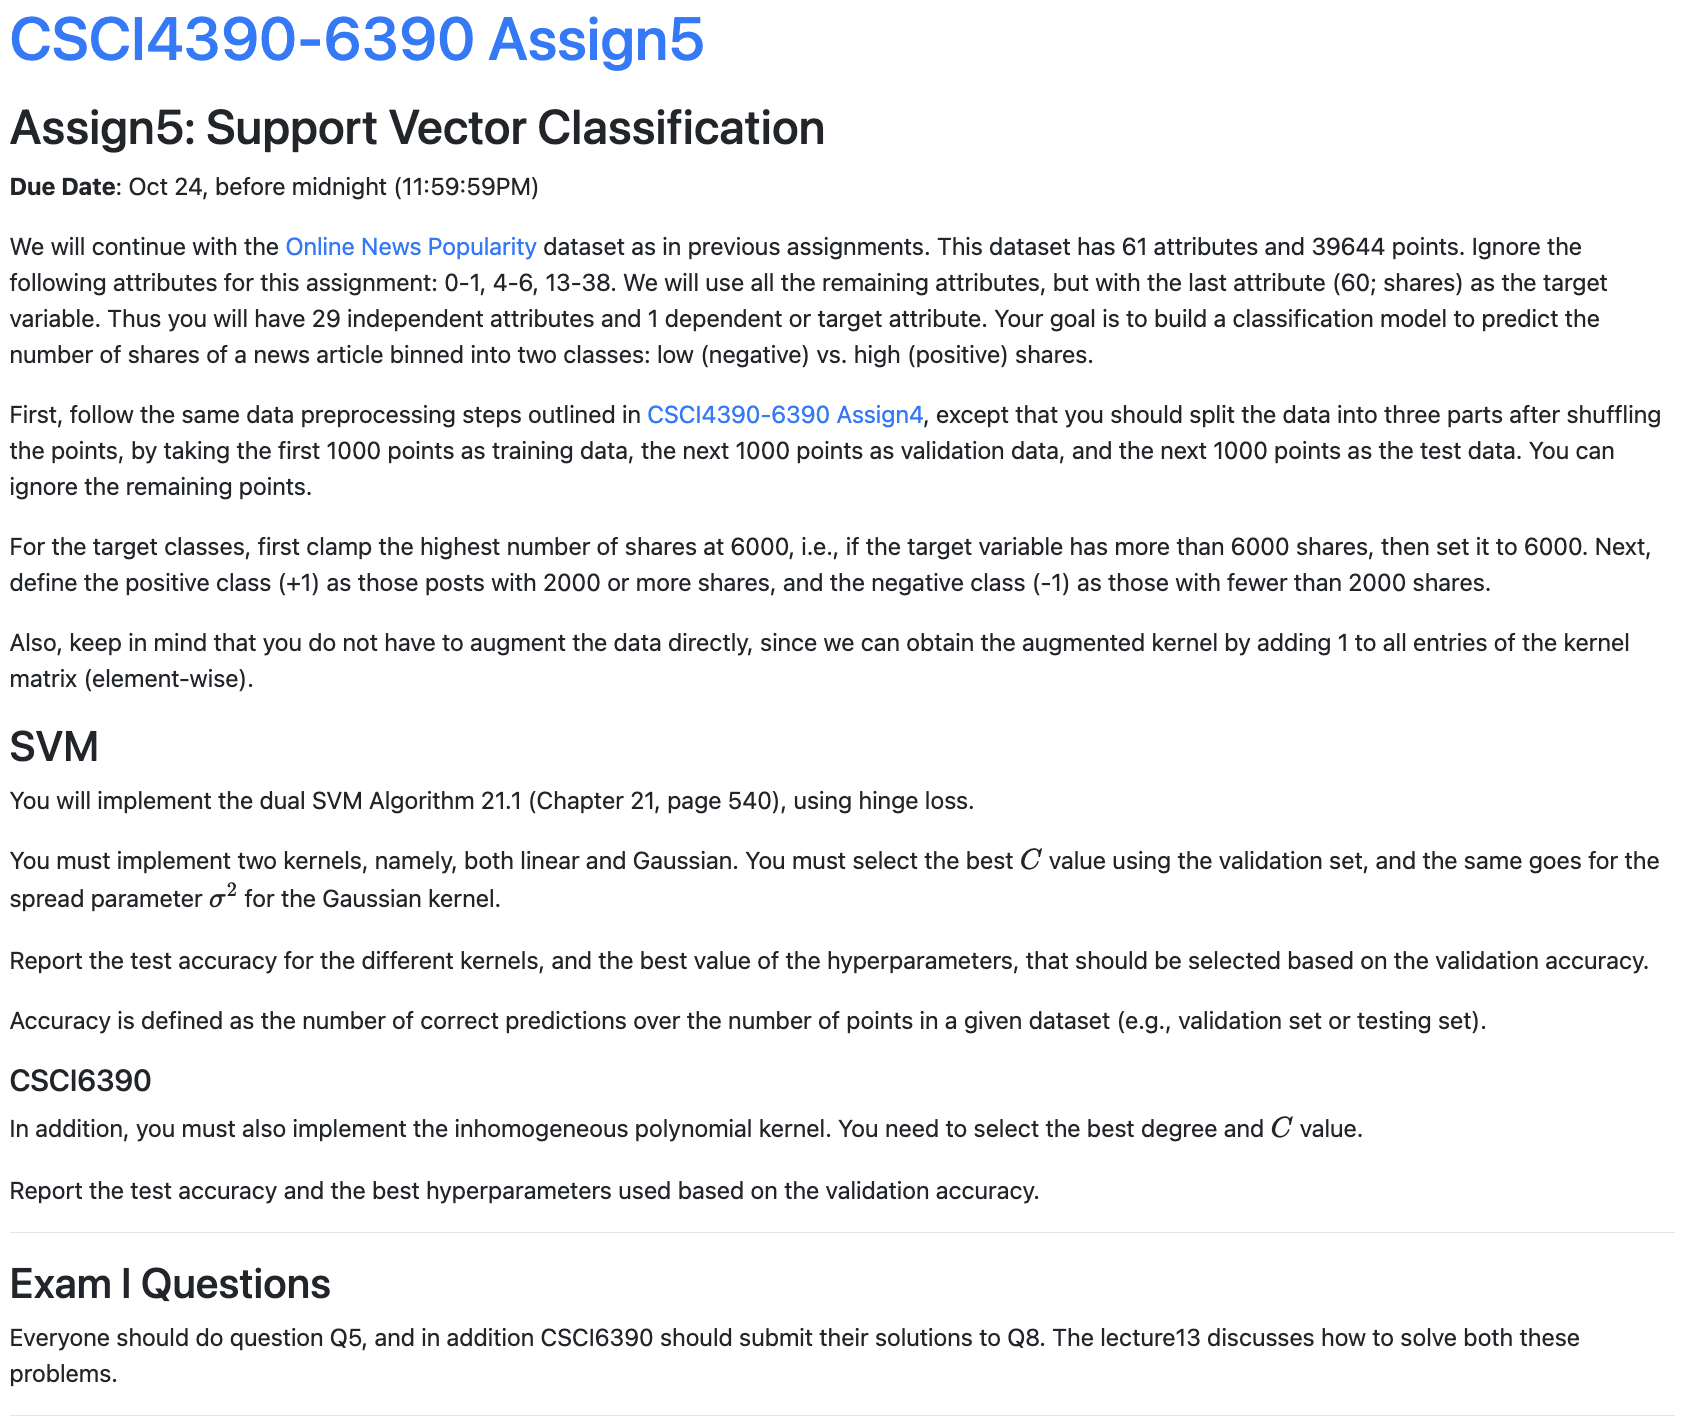

In [1]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('OnlineNewsPopularity.csv')

In [3]:
c1 = df[df.columns[2:4]]
c2 = df[df.columns[7:13]]
c3 = df[df.columns[39:]]
df = pd.concat([c1, c2, c3], axis=1)
D = df.to_numpy()
D

array([[1.20000000e+01, 2.19000000e+02, 4.00000000e+00, ...,
        0.00000000e+00, 1.87500000e-01, 5.93000000e+02],
       [9.00000000e+00, 2.55000000e+02, 3.00000000e+00, ...,
        5.00000000e-01, 0.00000000e+00, 7.11000000e+02],
       [9.00000000e+00, 2.11000000e+02, 3.00000000e+00, ...,
        5.00000000e-01, 0.00000000e+00, 1.50000000e+03],
       ...,
       [1.00000000e+01, 4.42000000e+02, 2.40000000e+01, ...,
        4.54545455e-02, 1.36363636e-01, 1.90000000e+03],
       [6.00000000e+00, 6.82000000e+02, 1.00000000e+01, ...,
        5.00000000e-01, 0.00000000e+00, 1.10000000e+03],
       [1.00000000e+01, 1.57000000e+02, 1.00000000e+00, ...,
        1.66666667e-01, 2.50000000e-01, 1.30000000e+03]])

In [4]:
D.shape

(39644, 30)

In [5]:
np.random.seed(42)
np.random.shuffle(D)
Y = D[:,-1]
Y[Y>6000] = 6000
Y[Y<2000] = int(-1)
Y[Y>=2000] = int(1)
D = D[:,0:28]

In [6]:

train = D[0:1000]
train_Y = Y[0:1000]
print('train : ', train.shape, 'train_Y : ', train_Y.shape)
valid = D[1000:2000]
valid_Y = Y[1000:2000]
print('valid : ', valid.shape, 'valid_Y : ', valid_Y.shape)
test = D[2000:3000]
test_Y = Y[2000:3000]
print('test : ', test.shape, 'test_Y : ', test_Y.shape)
Y

train :  (1000, 28) train_Y :  (1000,)
valid :  (1000, 28) valid_Y :  (1000,)
test :  (1000, 28) test_Y :  (1000,)


array([ 1., -1.,  1., ..., -1., -1., -1.])

## Dual SVM with stochastic gradient decent 

In [7]:
def SVM(K,y,c,e):
    one = np.ones(K.shape[0])
    K1 = np.insert(K, -1, one, axis=1)

    n = train.shape[0]
    nta = np.zeros(n)
    for i in range(n):
        nta[i] = 1/K1[i][i]
    t=0
    alpha = np.zeros(n)

    while(True):
        alphaold = alpha.copy()
        for k in range(n):
            '''
            a=0
            for i in range(n):
                a += alpha[i]* y[i]* K1[i][k]
            '''
            alpha[k] = alpha[k] + nta[k]*(1 - np.dot(alpha * y, K[:,i]))
            if alpha[k]<0: 
                alpha[k]=0
            elif alpha[k]>c: 
                alpha[k]=c
        if np.linalg.norm(alpha - alphaold)<= e:
            break
        #alphaold = alpha
        t += 1
    print('t',t)
    return alpha
        
                
        
        
        

## linear Kernel

In [8]:

K = np.dot(train, train.T)
aph = SVM(K, train_Y,1,0.00001) 
sup = np.where(aph > 1e-8)[0]
w = np.dot(aph * train_Y, train)
b=0
for i in sup:
    b += train_Y - np.dot(w, train[i])
b = b/len(sup)
pred = np.sign(np.dot(train, w) + b)
acc = np.sum(pred == train_Y)/train.shape[0]
print('accuracy: ',acc)

t 11
accuracy:  0.934


## validation data linear Kernel

In [9]:
KV = np.dot(valid, valid.T)
aph = SVM(K, valid_Y,1,0.0000001) 
sup = np.where(aph > 1e-8)[0]
w = np.dot(aph * valid_Y, valid)
b=0
for i in sup:
    b += valid_Y - np.dot(w, valid[i])
b = b/len(sup)
pred = np.sign(np.dot(valid, w) + b)
acc = np.sum(pred == valid_Y)/valid.shape[0]
print('accuracy: ',acc)

t 26
accuracy:  0.931


The best spread value for linear Kernel is 1 and the accuracy is 0.931

## inhomogeneous polynomial Kernel

In [10]:
c = 100000
QK = (c + K)**2
aph = SVM(QK, train_Y,1,0.0000000001) 
sup = np.where(aph > 1e-13)[0]
w = np.dot(aph * train_Y, train)
b=0
for i in sup:
    b += train_Y - np.dot(w, train[i])
b = b/len(sup)
pred = np.sign(np.dot(train, w) + b)
acc = np.sum(pred == train_Y)/train.shape[0]
print('accuracy: ',acc)

t 0
accuracy:  1.0


## validation data inhomogeneous polynomial Kernel

In [11]:
c = 10000
QK = (c + KV)**2
aph = SVM(QK, valid_Y,0.1,0.0000001) 
sup = np.where(aph > 1e-12)[0]
w = np.dot(aph * valid_Y, valid)
b=0
for i in sup:
    b += valid_Y - np.dot(w, valid[i])
b = b/len(sup)
pred = np.sign(np.dot(valid, w) + b)
acc = np.sum(pred == valid_Y)/valid.shape[0]
print('accuracy: ',acc)

t 0
accuracy:  1.0


The best spread value for inhomogeneous polynomial Kernel is 0.1  and the accuracy is 1

## Gaussian Kernel

In [12]:
spread = 99000000000000000
dt = np.diag(K)
dd = np.reshape(dt, (1000, 1))
GK = (2 * K - dt - dd) / (2 * spread)
GK = np.exp(GK)
aph = SVM(GK, train_Y,spread,0.00001) 
sup = np.where(aph > 1e-10)[0]
w = np.dot(aph * train_Y, train)
b=0
for i in sup:
    b += train_Y - np.dot(w, train[i])
b = b/len(sup)
pred = np.sign(np.dot(train, w) + b)
acc = np.sum(pred == train_Y)/train.shape[0]
print('accuracy: ',acc)

t 1
accuracy:  0.604


## validation data Gaussian Kernel

In [13]:
spread = 90000000
dt = np.diag(KV)
dd = np.reshape(dt, (1000, 1))
GK = (2 * KV - dt - dd) / (2 * spread)
GK = np.exp(GK)
aph = SVM(GK, valid_Y,spread,0.0000001) 
sup = np.where(aph > 1e-00001)[0]
w = np.dot(aph * valid_Y, valid)
b=0
for i in sup:
    b += valid_Y - np.dot(w, valid[i])
b = b/len(sup)
pred = np.sign(np.dot(valid, w) + b)
acc = np.sum(pred == valid_Y)/valid.shape[0]
print('accuracy: ',acc)

t 1
accuracy:  0.613


The best spread value for gaussian Kernel is 90000000 and the accuracy is 0.613

## Exam 1 Question 5

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('./seeds_dataset.txt', sep="\t", header=None)
df = df[df.columns[0:7]]
D = np.array(df)

n = df.shape[0]
d = df.shape[1]


In [15]:
def phiofx(arr):
    ar = np.zeros(d*4)
    itr = 0
    for i in range(d):
        for j in range(i, d):
            if i == j:
                ar[itr] = arr[j] * arr[i]
            else:
                ar[itr] = np.sqrt(2) * arr[j] * arr[i]
            itr += 1
            
    return ar
    

In [16]:
X = np.zeros([n,d*4])
print(X.shape)
for i in range(n):
    a=phiofx(D[i][:])
    X[i][:] = a
cov = np.cov(X.T, bias=True)
ival,ivec = np.linalg.eigh(cov)
ivec = np.flip(ivec, axis=1)
print('Best direction in quadratic space:\n',ivec[:,0])

(210, 28)
Best direction in quadratic space:
 [-6.14781397e-01 -6.10913284e-01 -2.62906997e-02 -2.24972040e-01
 -1.46798782e-01 -7.15891808e-02 -2.22498680e-01 -2.63633966e-01
 -1.27865332e-02 -1.33307258e-01 -9.32728109e-02 -1.05458329e-02
 -1.33124652e-01 -1.55487710e-04 -4.30815137e-03 -3.43997711e-03
  1.79866636e-03 -4.39761953e-03 -3.34874838e-02 -3.36473658e-02
 -8.82792529e-04 -4.73779638e-02 -1.63031868e-02 -5.28717940e-03
 -3.35283471e-02  1.68706633e-02 -1.29344015e-03 -3.34370238e-02]


## Exam 1 question 8

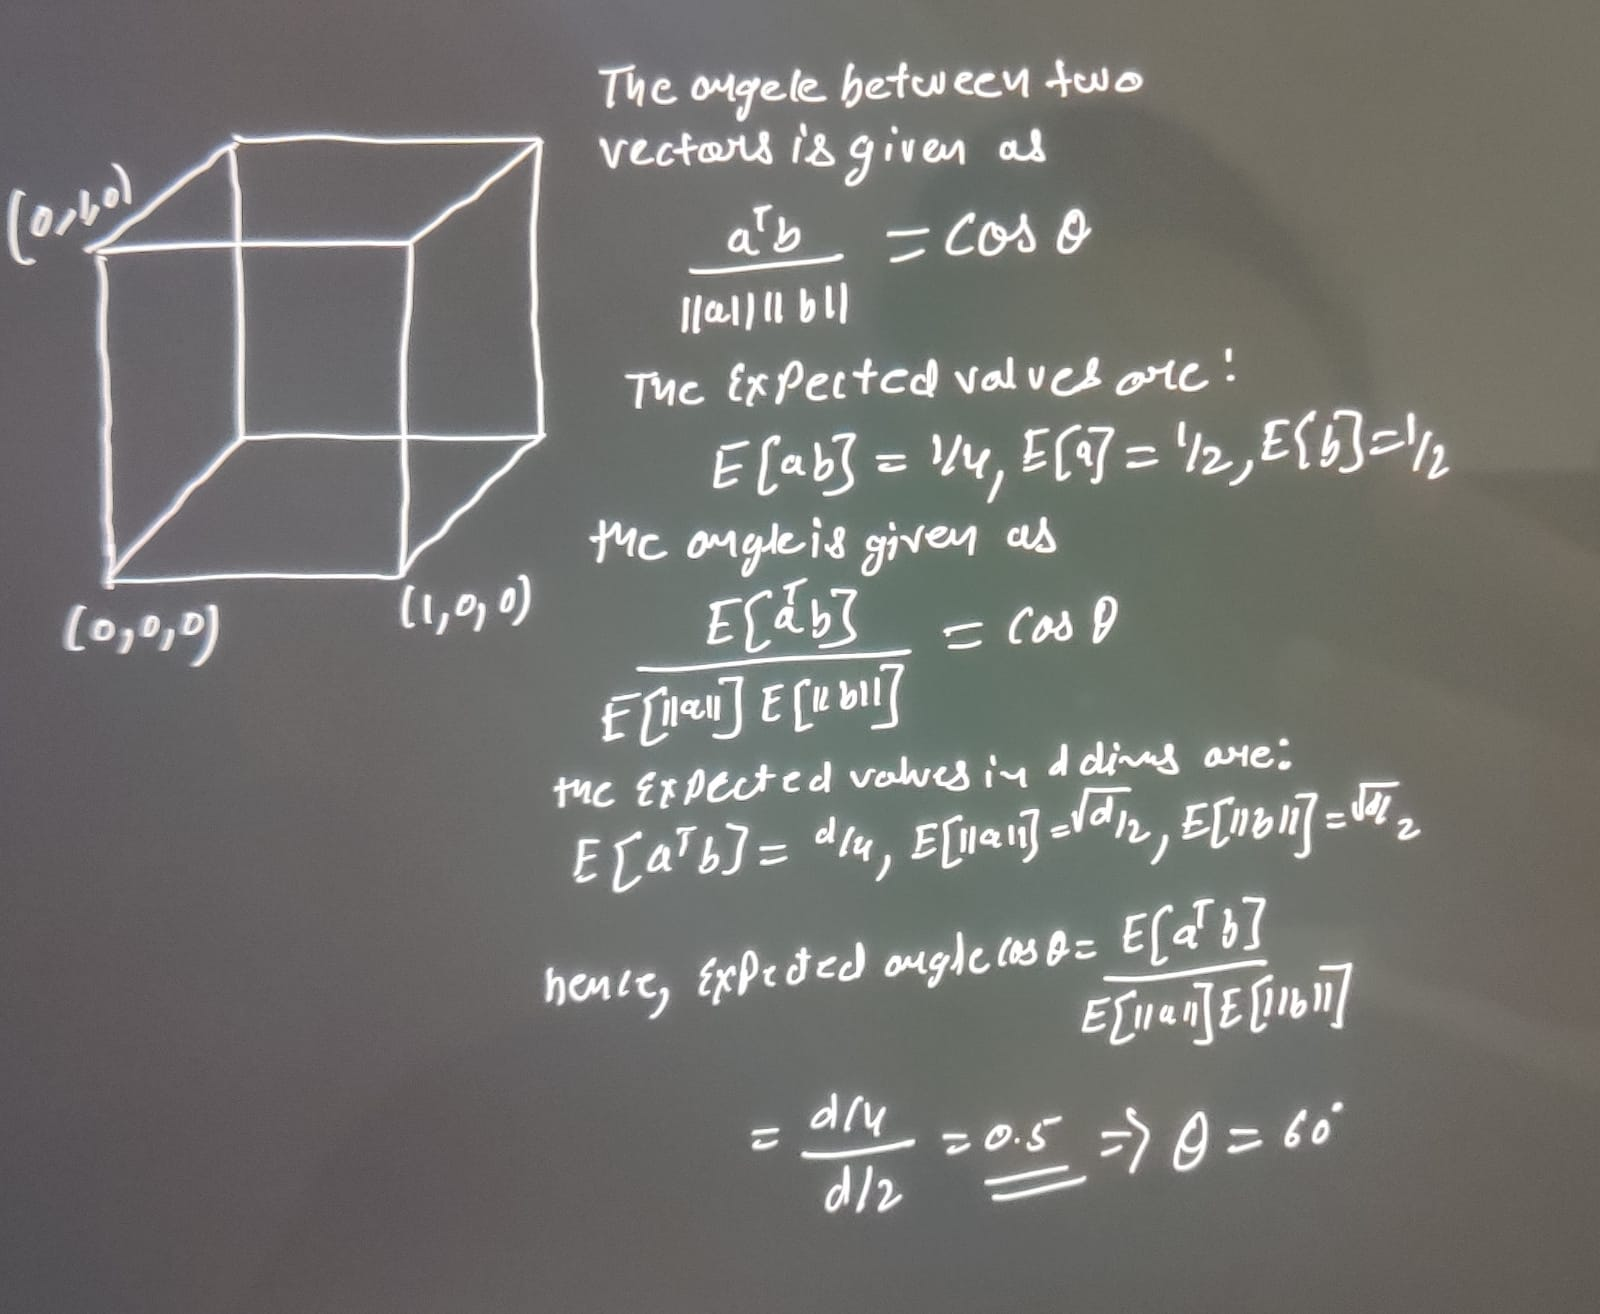